# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

In [1]:
# pip install pyfinance

## Imports & Settings

In [2]:
# %matplotlib inline

import warnings
from datetime import datetime
import os
from pathlib import Path
import quandl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
from pyfinance.ols import PandasRollingOLS
from sklearn.feature_selection import mutual_info_classif

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

## Get Data

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
import sys
# sys.path.append('/codeload/Hands-On-Machine-Learning-for-Algorithmic-Trading')
sys.path.append('/home/rodrigo/repo/finance/Hands-On-Machine-Learning-for-Algorithmic-Trading')


from common.data import get_qr_prices

In [5]:
metadata, prices = get_qr_prices(start_date="2013-05-24", end_date='2023-03-31')


In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3182 entries, FIBBG000B9WP24 to FIBBG01G9TL4C5
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ticker                  3182 non-null   object        
 1   name                    3182 non-null   object        
 2   last_sale               3182 non-null   object        
 3   net_change              3182 non-null   float64       
 4   perc_change             3182 non-null   object        
 5   market_cap              3182 non-null   float64       
 6   country                 3182 non-null   object        
 7   ipo_year                3182 non-null   float64       
 8   volume                  3182 non-null   int64         
 9   sector                  3182 non-null   object        
 10  industry                3182 non-null   object        
 11  exchange                3182 non-null   object        
 12  Symbol                  3182 n

In [7]:
metadata

,ticker,name,last_sale,net_change,perc_change,market_cap,country,ipo_year,volume,sector,industry,exchange,Symbol,Exchange,Name,Delisted,alpaca_Status,usstock_FirstPriceDate
Sid,,,,,,,,,,,,,,,,,,
FIBBG000B9WP24,MPU,Mega Matrix Corp. Common Stock,$1.57,0.0400,2.614%,4.955556e+07,United States,1998.0,285,Consumer Discretionary,Diversified Commercial Services,Nyse,MPU,XASE,AEROCENTURY CORP,False,active,2007-01-03
FIBBG000B9X2W1,DMF,BNY Mellon Municipal Income Inc. Common Stock,$6.2697,-0.0003,-0.005%,1.301418e+08,United States,1988.0,10315,Finance,Finance/Investors Services,Nyse,DMF,XASE,BNYM MUNICIPAL INCOME,False,active,2007-01-03
FIBBG000B9XRY4,AAPL,Apple Inc. Common Stock,$164.8899,-1.7601,-1.056%,2.858752e+12,United States,1980.0,13288136,Technology,Computer Manufacturing,Nasdaq,AAPL,XNAS,APPLE INC,False,active,2007-01-03
FIBBG000B9Y7P7,CET,Central Securities Corporation Common Stock,$34.88,-0.0700,-0.20%,9.758163e+08,United States,1951.0,5127,Finance,Finance/Investors Services,Nyse,CET,XASE,CENTRAL SECURITIES CORP,False,active,2007-01-03
FIBBG000B9YSS8,CNSL,Consolidated Communications Holdings Inc. Comm...,$3.64,-0.0200,-0.546%,4.174362e+08,United States,2005.0,71121,Telecommunications,Telecommunications Equipment,Nasdaq,CNSL,XNAS,CONSOLIDATED COMMUNICATIONS,False,active,2007-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FIBBG01DR6S3G3,ISPR,Ispire Technology Inc. Common Stock,$8.30,0.1000,1.22%,4.374100e+08,United States,2023.0,982,Health Care,Medicinal Chemicals and Botanical Products,Nasdaq,ISPR,XNAS,ISPIRE TECHNOLOGY INC,False,active,2023-04-04
FIBBG01FF0XMN8,OAKUU,Oak Woods Acquisition Corporation Unit,$10.23,-0.0100,-0.098%,0.000000e+00,Canada,2023.0,1011,Consumer Discretionary,Other Consumer Services,Nasdaq,OAKUU,XNAS,OAK WOODS ACQUISITION CORP,False,active,2023-03-24
FIBBG01FRH5MK2,AMX,America Movil S.A.B. de C.V. American Deposita...,$21.24,-0.0400,-0.188%,6.714176e+10,Mexico,2023.0,6978,Telecommunications,Telecommunications Equipment,Amex,AMX,XNYS,AMERICA MOVIL SAB DE CV,False,active,2023-03-16


In [8]:
prices.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2481 entries, 2013-05-24 to 2023-03-31
Columns: 2808 entries, FIBBG000C2V3D6 to FIBBG01BJSG0L1
dtypes: float64(2808)
memory usage: 53.2 MB


In [9]:
prices

Sid,FIBBG000C2V3D6,FIBBG000V2S3P6,FIBBG000D6VW15,FIBBG000B9XRY4,FIBBG00161BCR0,FIBBG0025Y4RY4,FIBBG000CDY3H5,FIBBG00LLW2MF2,FIBBG000BKDWB5,FIBBG001Y2XS07,...,FIBBG01CCMR9Q3,FIBBG01BWV1TD1,FIBBG01FF0XMN8,FIBBG012R6HZS5,FIBBG0193SPK75,FIBBG014BGZST1,FIBBG00ZVXBQS5,FIBBG00MMNG1G9,FIBBG019KNC9S3,FIBBG01BJSG0L1
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-24,30.119,2.055,NaN,13.804,25.915,30.528,14.738,NaN,41.11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-28,30.674,2.032,NaN,13.689,25.505,30.494,15.026,NaN,42.21,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-29,30.423,1.987,NaN,13.798,24.767,29.480,14.873,NaN,41.51,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-30,30.423,1.992,NaN,14.004,24.447,29.930,14.963,NaN,41.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,30.027,1.956,NaN,13.947,24.007,28.680,14.855,NaN,41.20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,132.854,1.820,1.72,158.280,17.270,157.540,36.750,7.58,198.54,117.91,...,2.315,4.340,10.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-28,132.414,1.810,1.82,157.650,17.540,158.250,36.800,7.55,199.39,116.61,...,2.400,4.340,10.21,10.190,3.890,NaN,NaN,NaN,NaN,NaN
2023-03-29,133.632,1.830,1.83,160.770,18.000,158.000,36.700,7.62,199.65,118.80,...,1.880,4.280,10.21,10.195,3.793,3.50,NaN,NaN,NaN,NaN


## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [10]:
monthly_prices = prices.resample('M').last()

In [11]:
monthly_prices

Sid,FIBBG000C2V3D6,FIBBG000V2S3P6,FIBBG000D6VW15,FIBBG000B9XRY4,FIBBG00161BCR0,FIBBG0025Y4RY4,FIBBG000CDY3H5,FIBBG00LLW2MF2,FIBBG000BKDWB5,FIBBG001Y2XS07,...,FIBBG01CCMR9Q3,FIBBG01BWV1TD1,FIBBG01FF0XMN8,FIBBG012R6HZS5,FIBBG0193SPK75,FIBBG014BGZST1,FIBBG00ZVXBQS5,FIBBG00MMNG1G9,FIBBG019KNC9S3,FIBBG01BJSG0L1
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-31,30.027,1.956,NaN,13.947,24.007,28.680,14.855,NaN,41.20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-30,28.328,1.919,NaN,12.297,23.159,27.773,15.152,NaN,40.10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-31,29.634,2.362,NaN,14.033,24.315,30.836,17.310,NaN,48.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,30.899,2.046,NaN,15.209,22.221,28.890,17.229,NaN,49.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-30,34.031,2.172,10.00,14.882,23.059,30.327,16.528,NaN,53.20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,154.498,1.750,2.20,147.618,28.540,159.662,52.497,12.87,187.62,102.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,149.407,1.273,1.89,129.732,26.129,160.088,46.948,10.13,179.25,85.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-31,151.833,1.442,2.39,144.070,28.062,147.750,46.968,10.53,220.00,111.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119 entries, 2013-05-31 to 2023-03-31
Freq: M
Columns: 2808 entries, FIBBG000C2V3D6 to FIBBG01BJSG0L1
dtypes: float64(2808)
memory usage: 2.6 MB


To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [13]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
Sid,Date,,,,,,
FIBBG000C2V3D6,2014-05-31,0.053669,0.010305,0.000870,0.011017,0.023218,0.019793
FIBBG000V2S3P6,2014-05-31,0.283646,0.153897,0.072239,0.044182,0.017606,0.016981
FIBBG000B9XRY4,2014-05-31,0.078710,0.089002,0.065468,0.023798,0.031495,0.030944
FIBBG00161BCR0,2014-05-31,0.010302,0.008263,0.014515,0.018296,0.018825,0.007573
FIBBG0025Y4RY4,2014-05-31,0.043221,0.032703,0.024953,0.022135,0.030313,0.023271
...,...,...,...,...,...,...,...
FIBBG000BG80W7,2023-03-31,-0.031711,0.003306,0.009863,0.028260,0.015537,0.014463
FIBBG000BV2R33,2023-03-31,0.046455,0.055738,0.062328,0.055286,-0.015075,-0.001523
FIBBG000BD8ZK0,2023-03-31,0.073898,0.004165,0.078727,0.054071,0.016312,-0.007665


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 192093 entries, ('FIBBG000C2V3D6', Timestamp('2014-05-31 00:00:00')) to ('FIBBG000BHPFQ0', Timestamp('2023-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   192093 non-null  float64
 1   return_2m   192093 non-null  float64
 2   return_3m   192093 non-null  float64
 3   return_6m   192093 non-null  float64
 4   return_9m   192093 non-null  float64
 5   return_12m  192093 non-null  float64
dtypes: float64(6)
memory usage: 9.4+ MB


## Drop stocks with less than 5 yrs of returns

In [15]:
min_obs = 90
nobs = data.groupby(level='Sid').size()
keep = nobs[nobs>min_obs].index
data_n_returns = data.loc[idx[keep,:], :]


In [16]:
data_n_returns

return_1m  return_2m  return_3m  return_6m   
Sid            Date                                                     
FIBBG000B9WP24 2014-05-31  -0.136310  -0.058967  -0.044481  -0.005122  \
               2014-06-30  -0.011565  -0.076040  -0.043425  -0.016190   
               2014-07-31   0.013421   0.000850  -0.047134   0.001765   
               2014-08-31  -0.284211  -0.148298  -0.104963  -0.075216   
               2014-09-30  -0.003795  -0.155563  -0.102624  -0.073497   
...                              ...        ...        ...        ...   
FIBBG00R0TMXH1 2022-11-30   0.271048   0.099428  -0.041288  -0.062489   
               2022-12-31  -0.066914   0.089035   0.040922  -0.055534   
               2023-01-31   0.183991   0.051078   0.119809  -0.033839   
               2023-02-28   0.074335   0.127831   0.058774   0.007501   
               2023-03-31   0.247722   0.157787   0.166457   0.101903   

                           return_9m  return_12m  
Sid            Date                               
FIBBG000B9WP24 2014-05-31  -0.027137   -0.017415  
               2014-06-30  -0.030154   -0.018457  
               2014-07-31  -0.027582   -0.028120  
               2014-08-31  -0.039582   -0.047206  
               2014-09-30  -0.045889   -0.048803  
...                              ...         ...  
FIBBG00R0TMXH1 2022-11-30  -0.080522   -0.077429  
               2022-12-31  -0.088531   -0.076349  
               2023-01-31  -0.047195   -0.058306  
               2023-02-28  -0.023696   -0.047518  
               2023-03-31   0.013321   -0.030554  

[145642 rows x 6 columns]

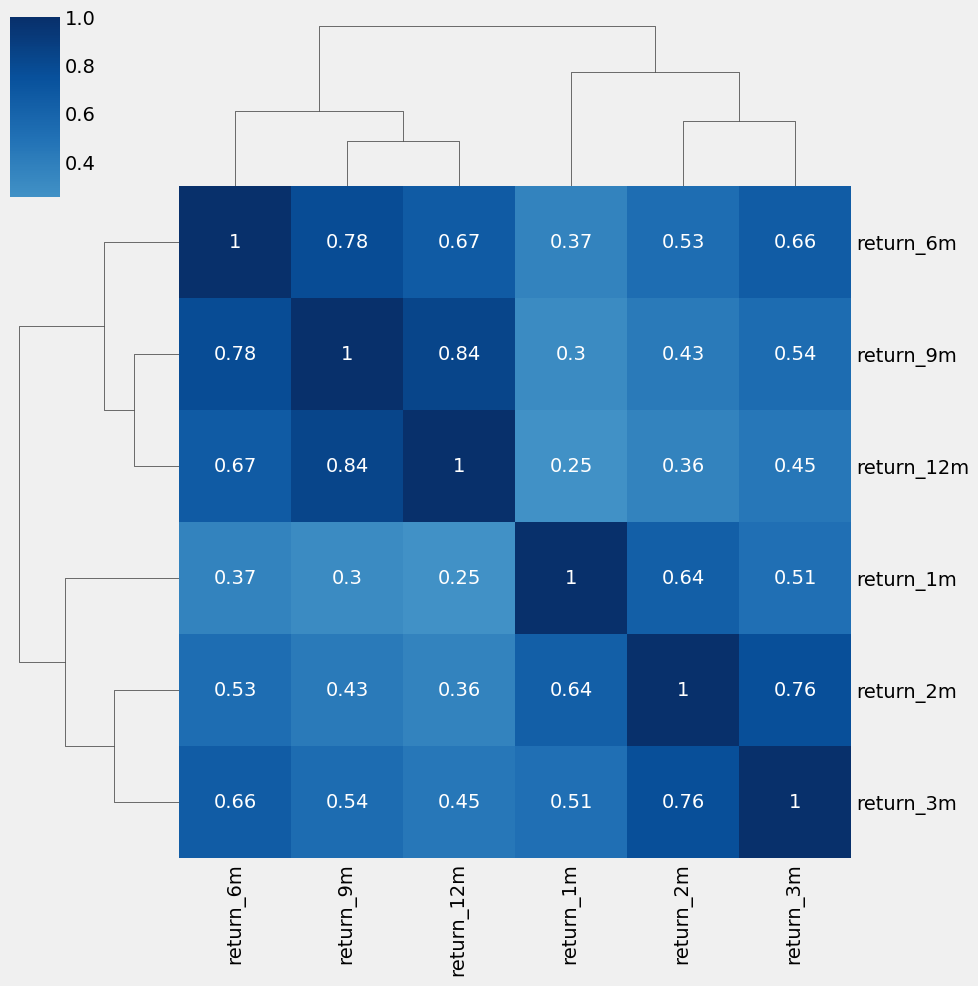

In [17]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data_n_returns.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,775 tickers.

In [18]:
data_n_returns.index.get_level_values('Sid').nunique()

1373

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [19]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2008')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'Date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2008-01-31 to 2023-03-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  183 non-null    float64
 1   SMB     183 non-null    float64
 2   HML     183 non-null    float64
 3   RMW     183 non-null    float64
 4   CMA     183 non-null    float64
dtypes: float64(5)
memory usage: 8.6 KB


In [20]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2008-01-31,-0.0636,-0.0066,0.0398,0.0214,0.0214
2008-02-29,-0.0309,-0.0066,-0.0084,0.0088,-0.0093
2008-03-31,-0.0093,0.0056,0.0030,0.0079,0.0050
2008-04-30,0.0460,-0.0114,-0.0104,0.0163,-0.0247
2008-05-31,0.0186,0.0306,-0.0149,0.0093,-0.0006
...,...,...,...,...,...
2022-11-30,0.0460,-0.0267,0.0138,0.0601,0.0311
2022-12-31,-0.0641,-0.0016,0.0132,0.0009,0.0419
2023-01-31,0.0665,0.0443,-0.0405,-0.0262,-0.0453


In [21]:
factor_data=factor_data.join(data_n_returns['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 145642 entries, ('FIBBG000B9WP24', Timestamp('2014-05-31 00:00:00')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     145642 non-null  float64
 1   SMB        145642 non-null  float64
 2   HML        145642 non-null  float64
 3   RMW        145642 non-null  float64
 4   CMA        145642 non-null  float64
 5   return_1m  145642 non-null  float64
dtypes: float64(6)
memory usage: 7.2+ MB


In [22]:
T = 24
betas = (factor_data
         .groupby(level='Sid', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), y=x.return_1m, x=x.drop('return_1m', axis=1)).beta))

In [23]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,114063.000000,114063.000000,114063.000000,114063.000000,114063.000000,114063.000000
mean,0.929965,0.531222,0.056923,-0.149110,0.009655,1.378655
std,0.839200,1.210654,1.134350,1.853223,1.779627,2.881623
min,-7.238729,-10.050575,-8.698585,-20.841960,-14.240393,-22.458014
25%,0.412222,-0.134312,-0.490657,-0.849098,-0.829634,-0.034501
50%,0.878969,0.357791,0.056027,-0.038043,-0.020551,1.142527
75%,1.348527,1.087594,0.629246,0.639580,0.788196,2.670888
max,8.750961,9.503401,11.674522,14.534950,14.446268,26.177835


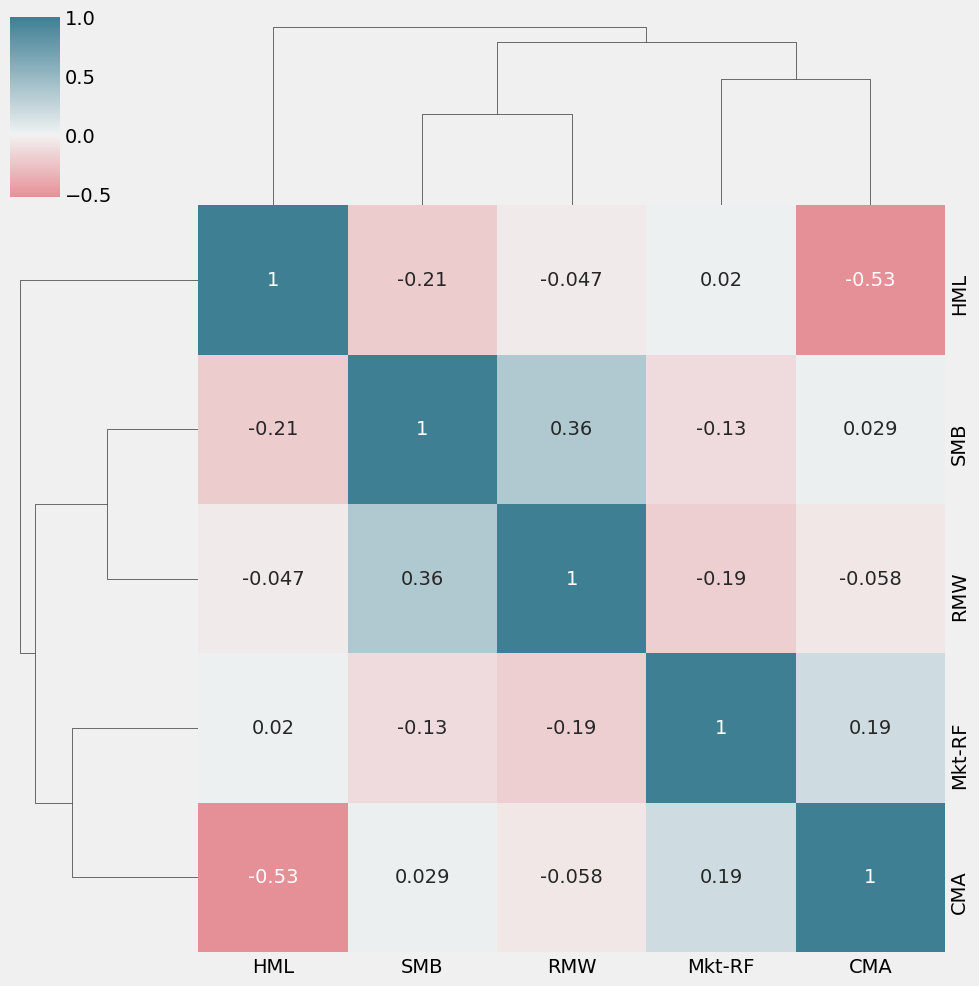

In [24]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [25]:
data_n_returns = (data_n_returns
        .join(betas
              .groupby(level='Sid')
              .shift()))
data_n_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 145642 entries, ('FIBBG000B9WP24', Timestamp('2014-05-31 00:00:00')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   145642 non-null  float64
 1   return_2m   145642 non-null  float64
 2   return_3m   145642 non-null  float64
 3   return_6m   145642 non-null  float64
 4   return_9m   145642 non-null  float64
 5   return_12m  145642 non-null  float64
 6   Mkt-RF      112690 non-null  float64
 7   SMB         112690 non-null  float64
 8   HML         112690 non-null  float64
 9   RMW         112690 non-null  float64
 10  CMA         112690 non-null  float64
dtypes: float64(11)
memory usage: 16.8+ MB


### Impute mean for missing factor betas

In [26]:
factors.append('Date')
filled_beta = data_n_returns.reset_index()

In [27]:
factors

['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Date']

In [29]:
data_n_returns.loc[:, factors] = (
    filled_beta.groupby('Sid')[factors]
    .apply(lambda x: x.fillna(x.mean()))
    .reset_index()
    .set_index(['Sid', 'Date'])
    .drop('level_1', axis=1)
)

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [30]:
for lag in [2,3,6,9,12]:
    data_n_returns[f'momentum_{lag}'] = data_n_returns[f'return_{lag}m'].sub(data_n_returns.return_1m)
data_n_returns[f'momentum_3_12'] = data_n_returns[f'return_12m'].sub(data_n_returns.return_3m)

## Date Indicators

In [31]:
dates = data_n_returns.index.get_level_values('Date')
data_n_returns['year'] = dates.year
data_n_returns['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [32]:
for t in range(1, 7):
    data_n_returns[f'return_1m_t-{t}'] = data_n_returns.groupby(level='Sid').return_1m.shift(t)
data_n_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 145642 entries, ('FIBBG000B9WP24', Timestamp('2014-05-31 00:00:00')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00'))
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      145642 non-null  float64
 1   return_2m      145642 non-null  float64
 2   return_3m      145642 non-null  float64
 3   return_6m      145642 non-null  float64
 4   return_9m      145642 non-null  float64
 5   return_12m     145642 non-null  float64
 6   Mkt-RF         145642 non-null  float64
 7   SMB            145642 non-null  float64
 8   HML            145642 non-null  float64
 9   RMW            145642 non-null  float64
 10  CMA            145642 non-null  float64
 11  Date           0 non-null       float64
 12  momentum_2     145642 non-null  float64
 13  momentum_3     145642 non-null  float64
 14  momentum_6     145642 non-null  float64
 15  momentum_9     145642 

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [33]:
for t in [1,2,3,6,12]:
    data_n_returns[f'target_{t}m'] = data_n_returns.groupby(level='Sid')[f'return_{t}m'].shift(-t)

In [34]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data_n_returns[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m   
Sid            Date                                                     
FIBBG000B9WP24 2014-08-31  -0.003795  -0.006664  -0.103672  -0.284211  \
               2014-09-30  -0.009524  -0.149790  -0.081925  -0.003795   
               2014-10-31  -0.270192  -0.116117  -0.107848  -0.009524   
               2014-11-30   0.070487  -0.013597   0.073515  -0.270192   
               2014-12-31  -0.091077   0.075031   0.150245   0.070487   
               2015-01-31   0.271496   0.293963   0.138915  -0.091077   
               2015-02-28   0.316826   0.077903  -0.034930   0.271496   
               2015-03-31  -0.117671  -0.173821  -0.138357   0.316826   
               2015-04-30  -0.226398  -0.148517  -0.116458  -0.117671   
               2015-05-31  -0.062796  -0.055761   0.078407  -0.226398   

                           return_2m  return_3m  return_1m_t-1  return_1m_t-2   
Sid            Date                                                             
FIBBG000B9WP24 2014-08-31  -0.148298  -0.104963       0.013421      -0.011565  \
               2014-09-30  -0.155563  -0.102624      -0.284211       0.013421   
               2014-10-31  -0.006664  -0.109448      -0.003795      -0.284211   
               2014-11-30  -0.149790  -0.103672      -0.009524      -0.003795   
               2014-12-31  -0.116117  -0.081925      -0.270192      -0.009524   
               2015-01-31  -0.013597  -0.107848       0.070487      -0.270192   
               2015-02-28   0.075031   0.073515      -0.091077       0.070487   
               2015-03-31   0.293963   0.150245       0.271496      -0.091077   
               2015-04-30   0.077903   0.138915       0.316826       0.271496   
               2015-05-31  -0.173821  -0.034930      -0.117671       0.316826   

                           return_1m_t-3  
Sid            Date                       
FIBBG000B9WP24 2014-08-31      -0.136310  
               2014-09-30      -0.011565  
               2014-10-31       0.013421  
               2014-11-30      -0.284211  
               2014-12-31      -0.003795  
               2015-01-31      -0.009524  
               2015-02-28      -0.270192  
               2015-03-31       0.070487  
               2015-04-30      -0.091077  
               2015-05-31       0.271496

In [35]:
data_n_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 145642 entries, ('FIBBG000B9WP24', Timestamp('2014-05-31 00:00:00')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00'))
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      145642 non-null  float64
 1   return_2m      145642 non-null  float64
 2   return_3m      145642 non-null  float64
 3   return_6m      145642 non-null  float64
 4   return_9m      145642 non-null  float64
 5   return_12m     145642 non-null  float64
 6   Mkt-RF         145642 non-null  float64
 7   SMB            145642 non-null  float64
 8   HML            145642 non-null  float64
 9   RMW            145642 non-null  float64
 10  CMA            145642 non-null  float64
 11  Date           0 non-null       float64
 12  momentum_2     145642 non-null  float64
 13  momentum_3     145642 non-null  float64
 14  momentum_6     145642 non-null  float64
 15  momentum_9     145642 

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [36]:
data_n_returns = (data_n_returns
        .join(pd.qcut(metadata.ipo_year, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data_n_returns.age = data_n_returns.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [38]:
size_factor = (monthly_prices
               .loc[data_n_returns.index.get_level_values('Date').unique(),
                    data_n_returns.index.get_level_values('Sid').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107 entries, 2023-03-31 to 2014-05-31
Columns: 1373 entries, FIBBG000B9WP24 to FIBBG00R0TMXH1
dtypes: float64(1373)
memory usage: 1.1 MB


In [39]:
msize = (size_factor
         .mul(metadata
              .loc[size_factor.columns, 'market_cap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [40]:
data_n_returns['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data_n_returns.msize = data_n_returns.msize.fillna(-1)

## Combine data

In [41]:
data_n_returns = data_n_returns.join(metadata[['sector']])
data_n_returns.sector = data_n_returns.sector.fillna('Unknown')

In [42]:
data_n_returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 145642 entries, ('FIBBG000B9WP24', Timestamp('2014-05-31 00:00:00')) to ('FIBBG00R0TMXH1', Timestamp('2023-03-31 00:00:00'))
Data columns (total 34 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      145642 non-null  float64
 1   return_2m      145642 non-null  float64
 2   return_3m      145642 non-null  float64
 3   return_6m      145642 non-null  float64
 4   return_9m      145642 non-null  float64
 5   return_12m     145642 non-null  float64
 6   Mkt-RF         145642 non-null  float64
 7   SMB            145642 non-null  float64
 8   HML            145642 non-null  float64
 9   RMW            145642 non-null  float64
 10  CMA            145642 non-null  float64
 11  Date           0 non-null       float64
 12  momentum_2     145642 non-null  float64
 13  momentum_3     145642 non-null  float64
 14  momentum_6     145642 non-null  float64
 15  momentum_9     145642 

In [43]:
data_n_returns

return_1m  return_2m  return_3m  return_6m   
Sid            Date                                                     
FIBBG000B9WP24 2014-05-31  -0.136310  -0.058967  -0.044481  -0.005122  \
               2014-06-30  -0.011565  -0.076040  -0.043425  -0.016190   
               2014-07-31   0.013421   0.000850  -0.047134   0.001765   
               2014-08-31  -0.284211  -0.148298  -0.104963  -0.075216   
               2014-09-30  -0.003795  -0.155563  -0.102624  -0.073497   
...                              ...        ...        ...        ...   
FIBBG00R0TMXH1 2022-11-30   0.271048   0.099428  -0.041288  -0.062489   
               2022-12-31  -0.066914   0.089035   0.040922  -0.055534   
               2023-01-31   0.183991   0.051078   0.119809  -0.033839   
               2023-02-28   0.074335   0.127831   0.058774   0.007501   
               2023-03-31   0.247722   0.157787   0.166457   0.101903   

                           return_9m  return_12m    Mkt-RF       SMB   
Sid            Date                                                    
FIBBG000B9WP24 2014-05-31  -0.027137   -0.017415  0.436090  1.233787  \
               2014-06-30  -0.030154   -0.018457  0.436090  1.233787   
               2014-07-31  -0.027582   -0.028120  0.436090  1.233787   
               2014-08-31  -0.039582   -0.047206  0.436090  1.233787   
               2014-09-30  -0.045889   -0.048803  0.436090  1.233787   
...                              ...         ...       ...       ...   
FIBBG00R0TMXH1 2022-11-30  -0.080522   -0.077429  1.298471  0.687217   
               2022-12-31  -0.088531   -0.076349  1.352327  0.394186   
               2023-01-31  -0.047195   -0.058306  1.345742  0.567264   
               2023-02-28  -0.023696   -0.047518  1.424238  0.682843   
               2023-03-31   0.013321   -0.030554  1.323342  0.491777   

                                HML       RMW  ...  return_1m_t-5   
Sid            Date                            ...                  
FIBBG000B9WP24 2014-05-31 -0.393423  0.026895  ...            NaN  \
               2014-06-30 -0.393423  0.026895  ...            NaN   
               2014-07-31 -0.393423  0.026895  ...            NaN   
               2014-08-31 -0.393423  0.026895  ...            NaN   
               2014-09-30 -0.393423  0.026895  ...            NaN   
...                             ...       ...  ...            ...   
FIBBG00R0TMXH1 2022-11-30  0.064534 -0.271027  ...      -0.107389   
               2022-12-31 -0.242316  0.246626  ...       0.033162   
               2023-01-31 -0.368810  0.240338  ...      -0.164469   
               2023-02-28 -0.367218  0.181245  ...      -0.270995   
               2023-03-31 -0.706255  0.219308  ...      -0.049020   

                           return_1m_t-6  target_1m  target_2m  target_3m   
Sid            Date                                                         
FIBBG000B9WP24 2014-05-31            NaN  -0.011565   0.000850  -0.104963  \
               2014-06-30            NaN   0.013421  -0.148298  -0.102624   
               2014-07-31            NaN  -0.284211  -0.155563  -0.109448   
               2014-08-31            NaN  -0.003795  -0.006664  -0.103672   
               2014-09-30            NaN  -0.009524  -0.149790  -0.081925   
...                                  ...        ...        ...        ...   
FIBBG00R0TMXH1 2022-11-30      -0.137201  -0.066914   0.051078   0.058774   
               2022-12-31      -0.107389   0.183991   0.127831   0.166457   
               2023-01-31       0.033162   0.074335   0.157787        NaN   
               2023-02-28      -0.164469   0.247722        NaN        NaN   
               2023-03-31      -0.270995        NaN        NaN        NaN   

                           target_6m  target_12m  age  msize   
Sid            Date                                            
FIBBG000B9WP24 2014-05-31  -0.104318   -0.045186    1      2  \
               2014-06-30  -0.092334   -0.049411

## Store data

We will use the data again in several later chapters, starting in [Chapter 6 on Linear Models](../../06_machine_learning_process/02_mutual_information/mutual_information.ipynb).

In [44]:

with pd.HDFStore('../../data/assets.h5') as store:
    store.put('engineered_features', data_n_returns)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../../data/assets.h5
/engineered_features            frame        (shape->[145642,34])  
/quandl/wiki/prices             frame        (shape->[15389314,12])


## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [ ]:
# dummy_data = pd.get_dummies(data,
#                             columns=['year','month', 'msize', 'age',  'sector'],
#                             prefix=['year','month', 'msize', 'age', ''],
#                             prefix_sep=['_', '_', '_', '_', ''])
# dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
# dummy_data.info()